In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score,recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime


In [2]:
np.random.seed(42)
df=pd.read_csv("hackathon_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Order Date               2421 non-null   object 
 1   Requested Delivery Date  2421 non-null   object 
 2   Customer Country Code    2421 non-null   object 
 3   Product Code             2421 non-null   object 
 4   Description              2421 non-null   object 
 5   Order type               2421 non-null   object 
 6   Customer Order Code      2421 non-null   object 
 7   Value                    2421 non-null   float64
 8   Currency                 2421 non-null   object 
 9   Items                    2421 non-null   int64  
 10  Route                    2421 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.2+ KB


In [3]:
df.head(10)

Order Date Requested Delivery Date Customer Country Code Product Code   
0  26.04.2010              21.05.2010                    BG         P001  \
1  18.07.2011              13.08.2011                    GB         P003   
2  12.09.2011              19.09.2011                    FI         P001   
3  07.02.2011              06.03.2011                    PL         P002   
4  19.01.2010              17.02.2010                    CZ         P003   
5  16.04.2011              15.05.2011                    IT         P001   
6  14.05.2011              07.06.2011                    DE         P001   
7  20.01.2009              27.01.2009                    PT         P002   
8  17.11.2011              23.11.2011                    ES         P001   
9  23.06.2011              01.07.2011                    LI         P002   

                 Description Order type                   Customer Order Code   
0               Winter Parka         VO  5cf5079b-121f-411a-8f06-47ea419856e9  \
1  Siberian Expedition Parka         VO  31dcbf31-3a58-446f-a68e-ff3cfd5f291c   
2               Winter Parka         VO  0f41d2b4-159d-4c68-afd8-486119dd6e48   
3    Outdoor Adventure Parka         VO  9c5227ac-cb07-44df-92e2-b243e77515d4   
4  Siberian Expedition Parka         VO  80c7583d-9851-4f3f-86f3-15fb3f5d67cc   
5               Winter Parka         VO  7532b4c3-d9fe-48db-9dcc-7378e8dd6503   
6               Winter Parka         VO  67cfce11-34d3-4241-b767-6ad3a62ee87a   
7    Outdoor Adventure Parka         VO  ab8d10cb-47b4-481b-bc92-9b7399b4ca93   
8               Winter Parka         VO  2eaf232c-1e88-4b01-af20-391f9ec237bf   
9    Outdoor Adventure Parka         VO  4371f590-18a5-434b-b23a-116647b2165f   

    Value Currency  Items    Route  
0  148.98      BGN     24   Route7  
1  218.10      GBP     21   Route2  
2  212.25      EUR     42  Route42  
3  189.84      PLN     28   Route1  
4  168.05      CZK     24  Route14  
5  175.99      EUR     31  Route23  
6  207.25      EUR     49  Route25  
7  215.47      EUR     42   Route5  
8  297.04      EUR     47  Route15  
9  227.14      CHF     31  Route11

# PART 1 - Seasonal Choice Model

## EDA -1

In [4]:
# Duplicate, Missing values and Unique values Check
missing_values = df.isnull().sum()
duplicated  = df.duplicated().sum()
datatypes  = df.dtypes
unqiue = df.nunique()

columns  = pd.DataFrame({
    "missing_values":missing_values,
    "duplicated":duplicated,
    "datatypes":datatypes,
    "unqiue":unqiue,
})
columns

missing_values  duplicated datatypes  unqiue
Order Date                            0           0    object     979
Requested Delivery Date               0           0    object     976
Customer Country Code                 0           0    object      49
Product Code                          0           0    object       3
Description                           0           0    object       3
Order type                            0           0    object       1
Customer Order Code                   0           0    object    2421
Value                                 0           0   float64    2275
Currency                              0           0    object      25
Items                                 0           0     int64      31
Route                                 0           0    object      45

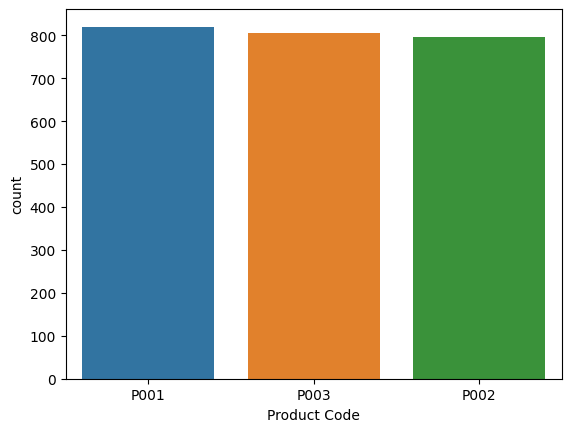

In [5]:
# Display the distribution of 'Product Code"
sns.countplot(x='Product Code', data=df)
plt.show()

In [6]:
# DataType Conversions
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y')
df['Requested Delivery Date'] = pd.to_datetime(df['Requested Delivery Date'], format='%d.%m.%Y')

In [7]:
# Feature engineering
# Extract month and day of the week from 'Order Date' and 'Requested Delivery Date'
df['OrderMonth'] = df['Order Date'].dt.month
df['OrderDayOfWeek'] = df['Order Date'].dt.dayofweek
df['DeliveryMonth'] = df['Requested Delivery Date'].dt.month
df['Shipping Duration'] = (df['Requested Delivery Date'] - df['Order Date']).dt.days

# Mapping months to seasons
season_mapping = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
df['Season'] = df['OrderMonth'].map(season_mapping)

In [8]:
# Handling missing values (To be used If they exist)
# Replace missing values for 'Value' with the mean Value
df['Value'].fillna(df['Value'].mean(), inplace=True)
df = df.dropna()  # Drop other rows with missing values

In [9]:
# Dropping Unnecessary Columns
df = df.drop(['Order type', 'Customer Order Code'], axis=1)  

In [10]:
#re-ordering columns (to put target variable column at the end)
desired_columns = [col for col in df.columns if col != 'Product Code'] + ['Product Code']
# Reorder the DataFrame columns
df = df[desired_columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Order Date               2421 non-null   datetime64[ns]
 1   Requested Delivery Date  2421 non-null   datetime64[ns]
 2   Customer Country Code    2421 non-null   object        
 3   Description              2421 non-null   object        
 4   Value                    2421 non-null   float64       
 5   Currency                 2421 non-null   object        
 6   Items                    2421 non-null   int64         
 7   Route                    2421 non-null   object        
 8   OrderMonth               2421 non-null   int32         
 9   OrderDayOfWeek           2421 non-null   int32         
 10  DeliveryMonth            2421 non-null   int32         
 11  Shipping Duration        2421 non-null   int64         
 12  Season                   2421 non-

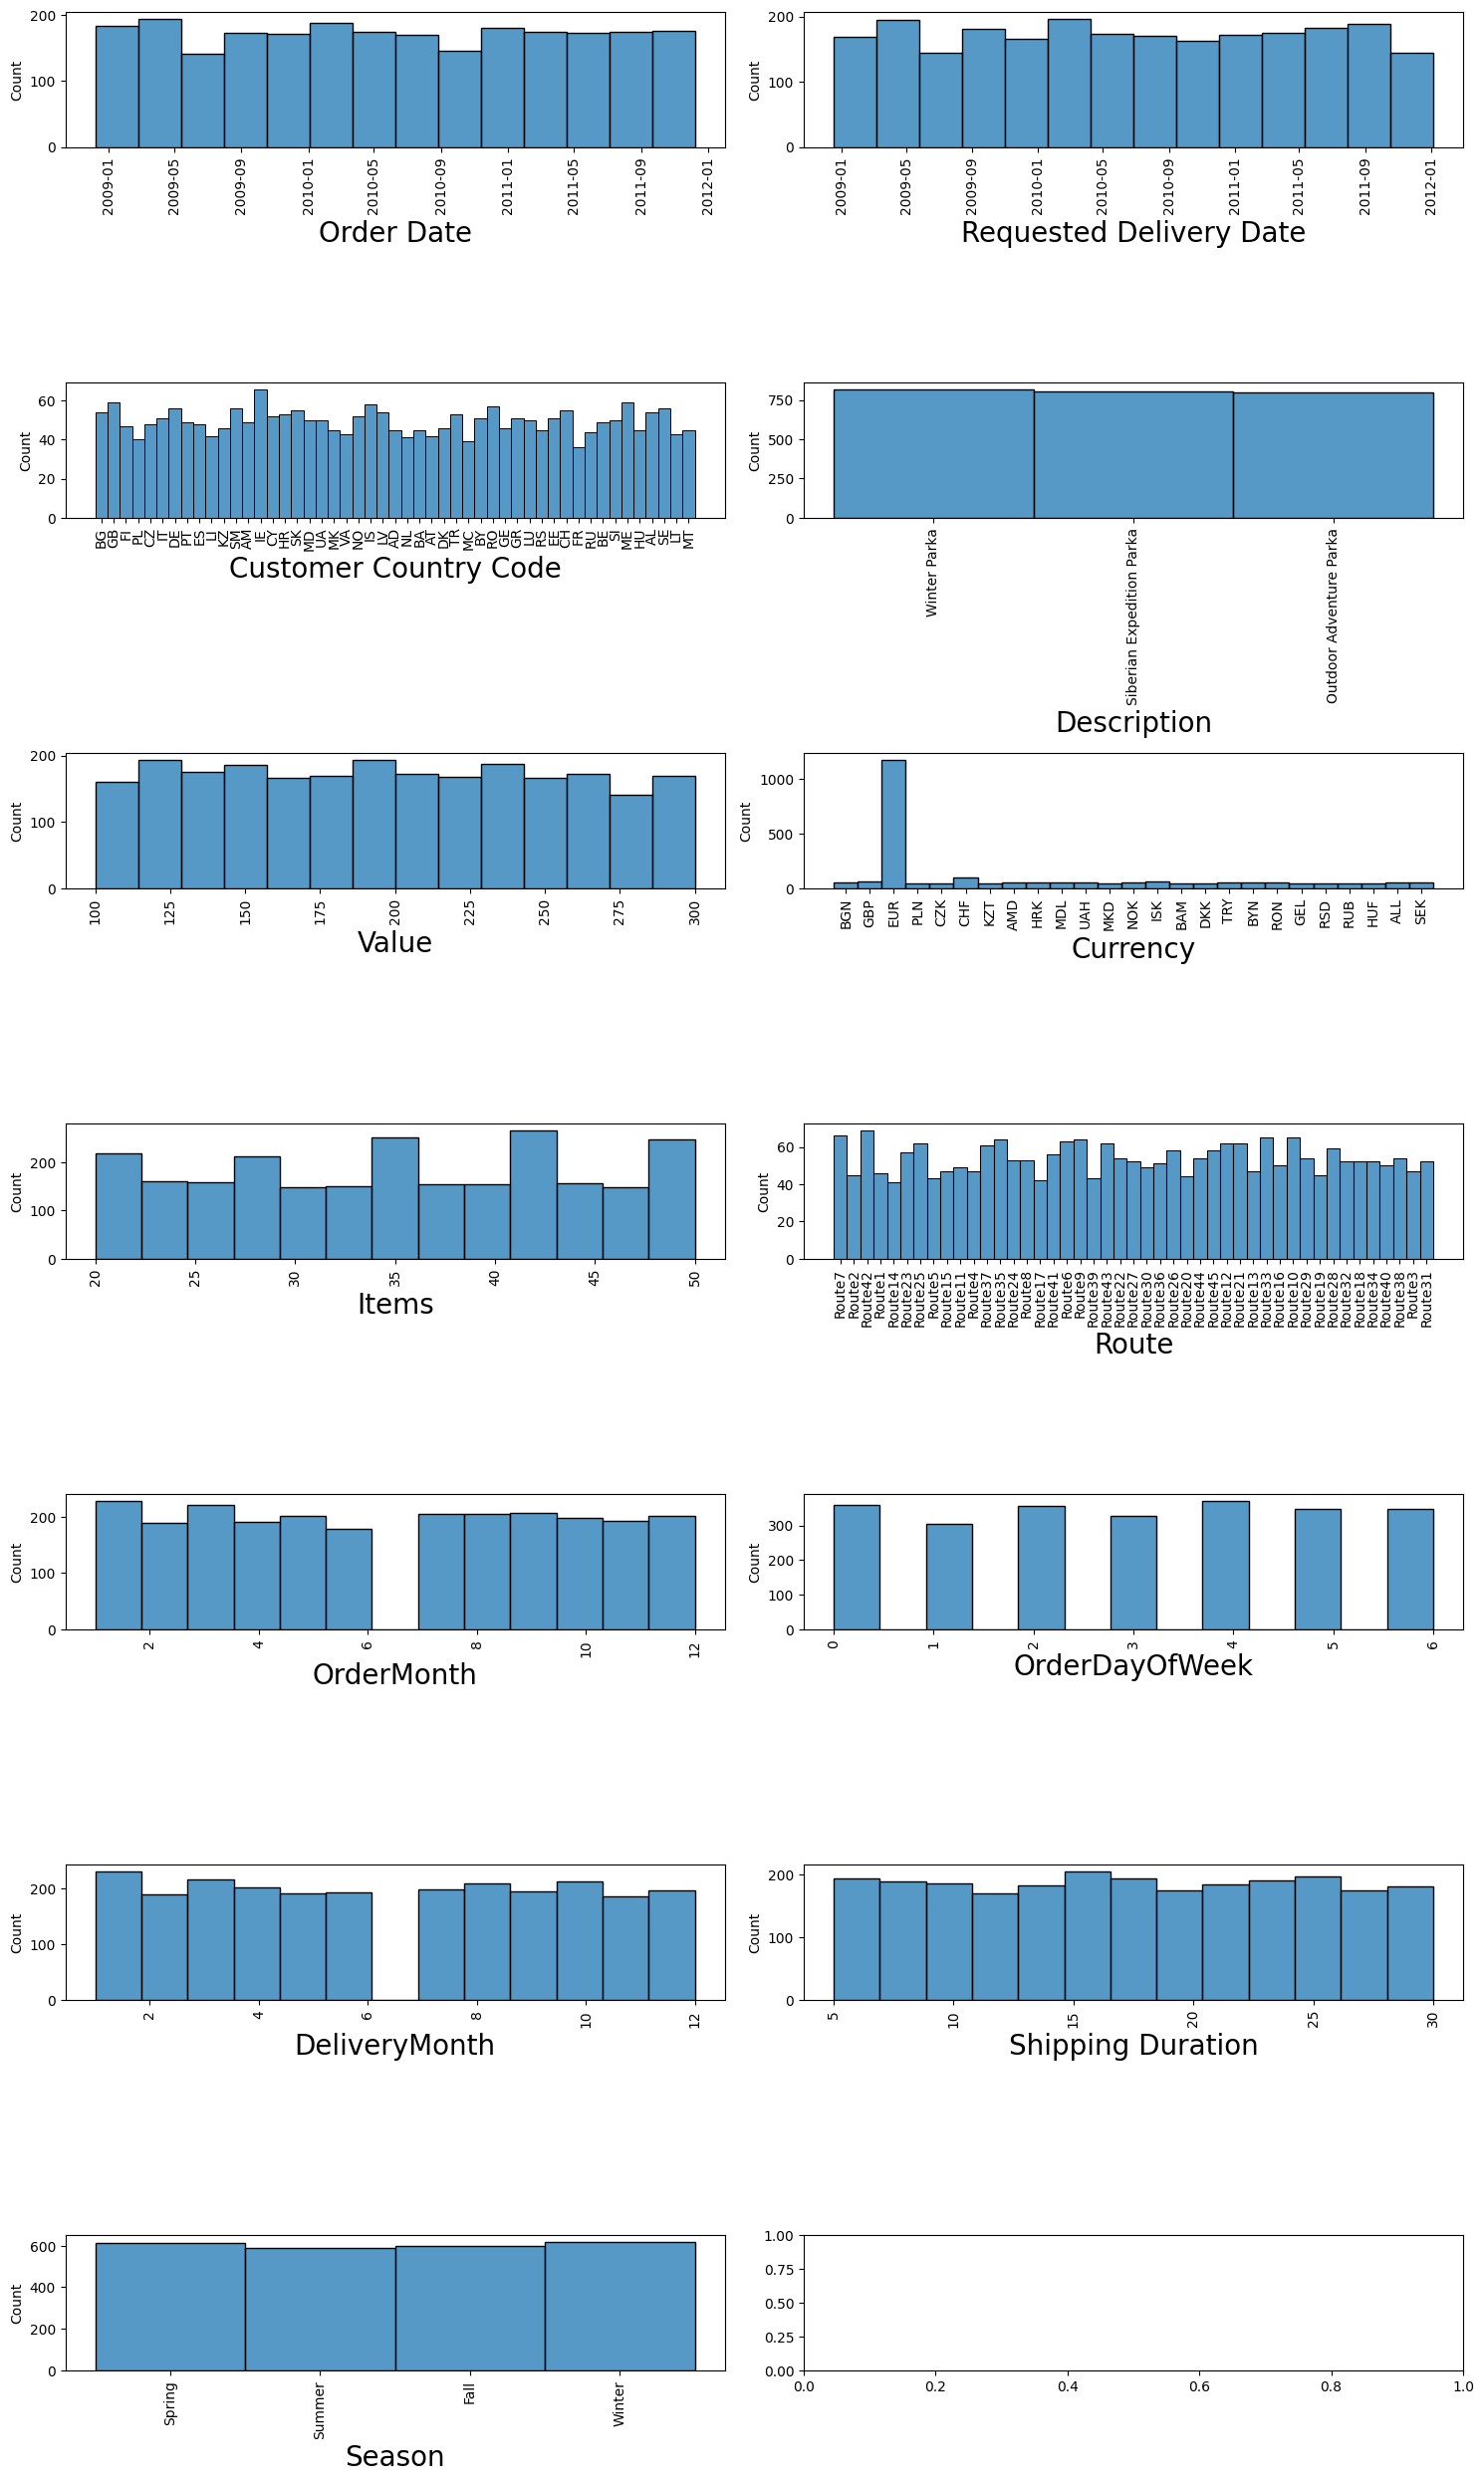

In [11]:
# Plotting Distribution of other variables

data = df.iloc[:, :-1] # exclude the last column because it is the target
num_cols = data.shape[1]
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 25))
axes = axes.flatten()

# Iterating over each column
for i, col in enumerate(data.columns):
    ax = axes[i]
    sns.histplot(x=data[col], ax=ax)
    ax.set_xlabel(col,fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
# Adjusting the spacing between subplots
plt.tight_layout()

# Displaying the plot
plt.show()

## Numeric Variable Analysis

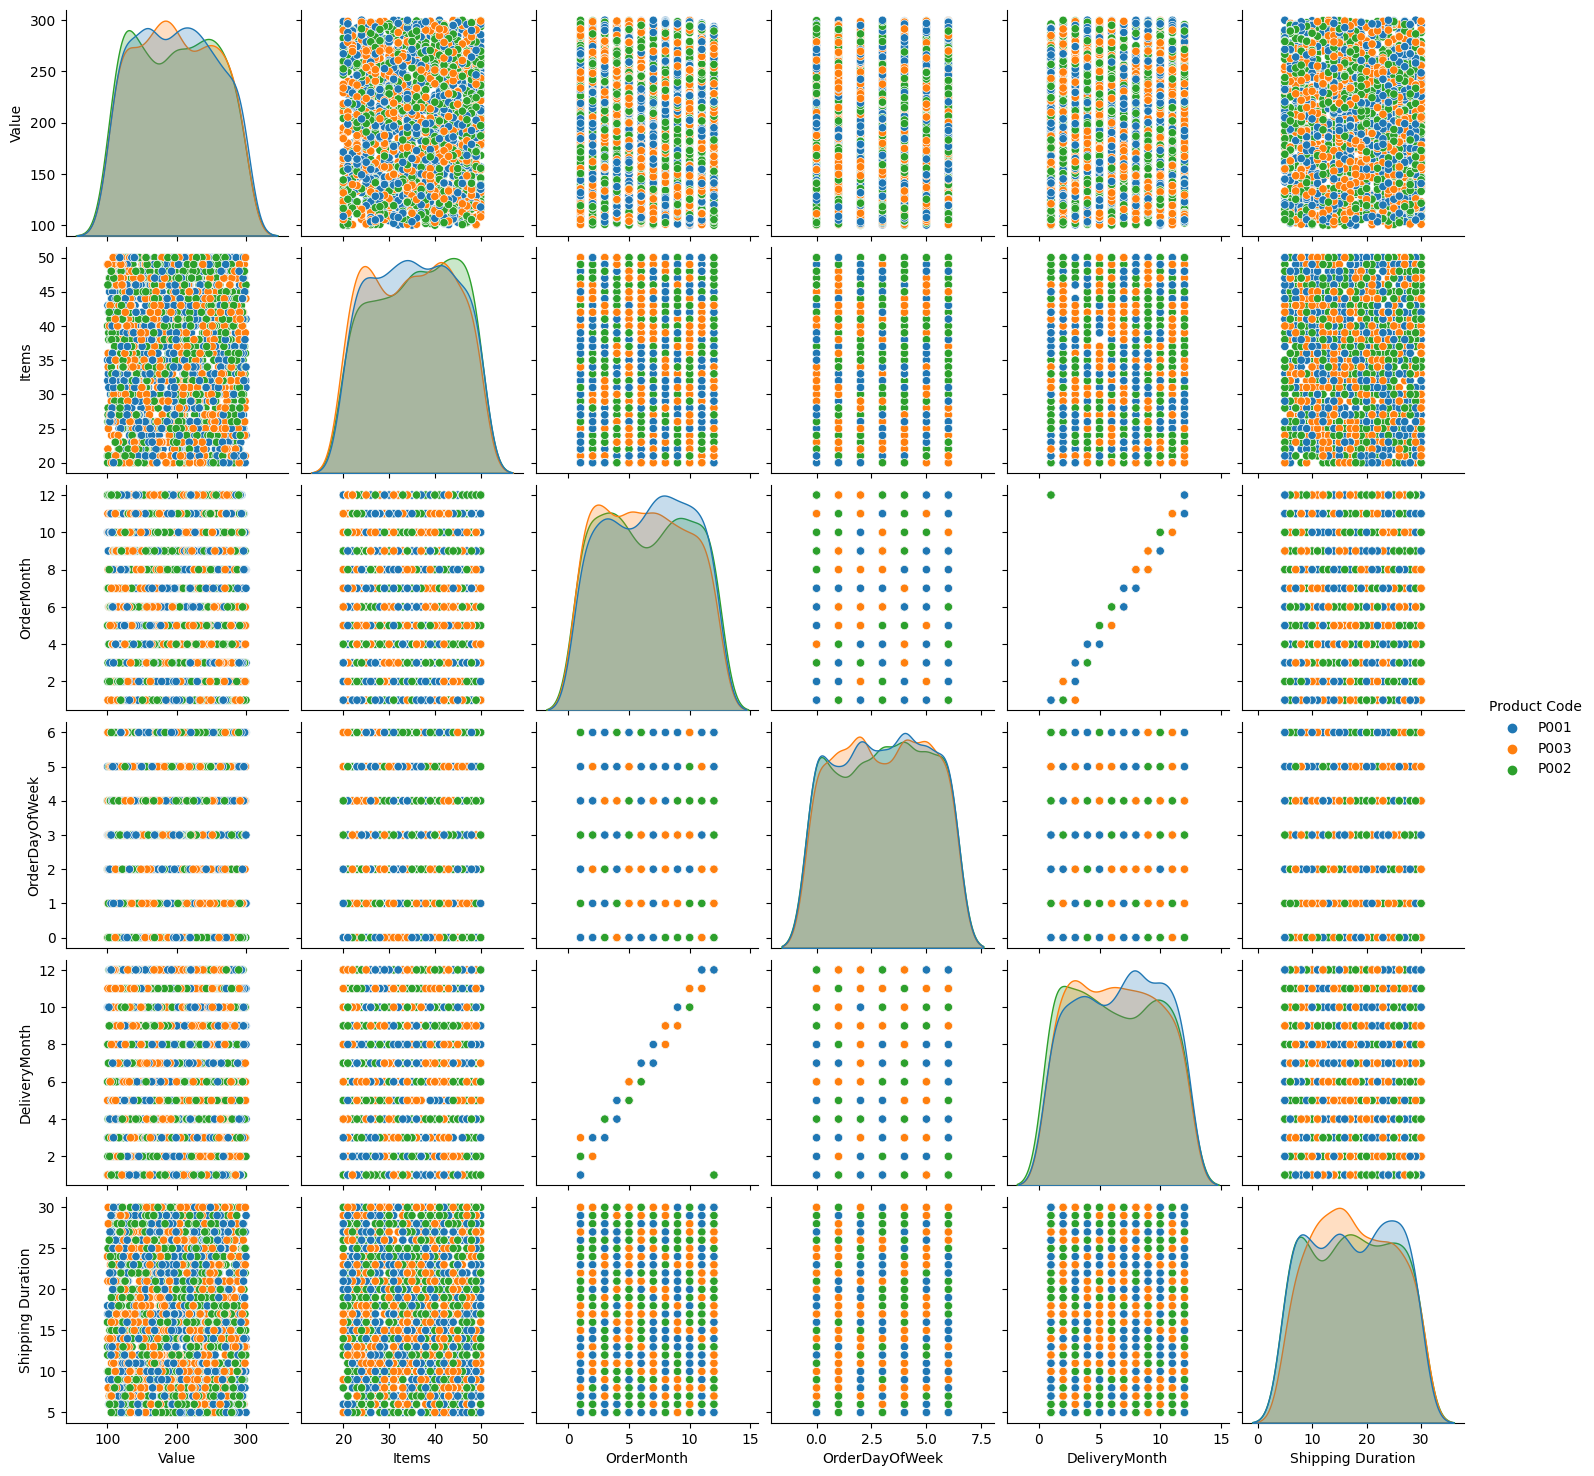

In [12]:
# More detailed exploration for each Product Type
sns.pairplot(df, hue='Product Code')
plt.show()

In [13]:
df[df['Shipping Duration']<0]

Empty DataFrame
Columns: [Order Date, Requested Delivery Date, Customer Country Code, Description, Value, Currency, Items, Route, OrderMonth, OrderDayOfWeek, DeliveryMonth, Shipping Duration, Season, Product Code]
Index: []

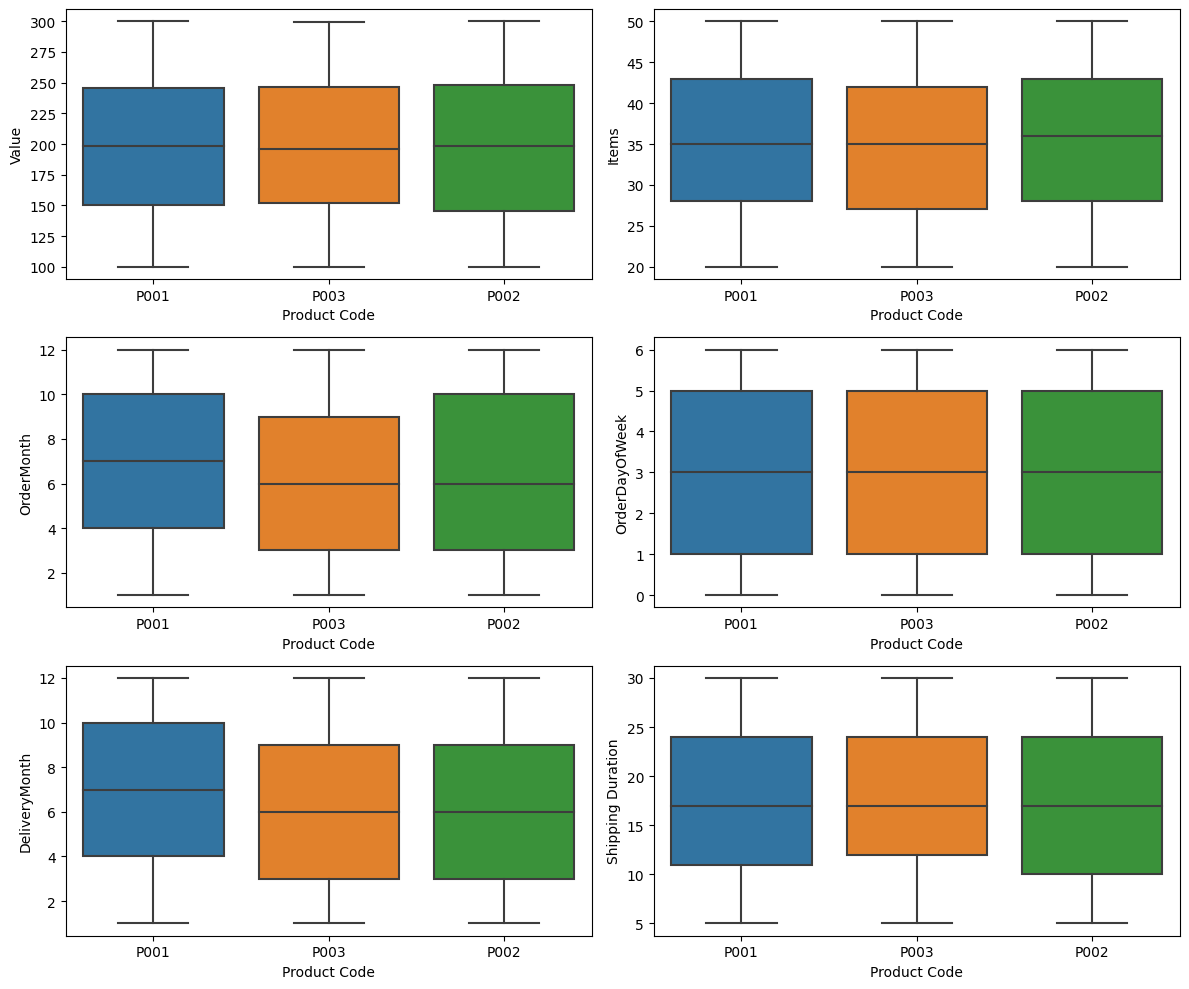

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
numerical_columns = df.select_dtypes(include=[np.number])  # select all numerical columns
for i, feature in enumerate(numerical_columns):
    row = i // 2
    col = i % 2
    sns.boxplot(x='Product Code', y=feature, data=df, ax=axs[row, col])

plt.tight_layout()
plt.show()

ASSUMING `values` and `items` `OrderMonth`,`OrderDayOfWeek`,`DeliveryMonth`,`Shipping Duration`are important

## Categorical Variable Analysis

In [15]:
non_numerical_columns = df.select_dtypes(exclude=['number']).dtypes
non_numerical_columns 

Order Date                 datetime64[ns]
Requested Delivery Date    datetime64[ns]
Customer Country Code              object
Description                        object
Currency                           object
Route                              object
Season                             object
Product Code                       object
dtype: object

In [16]:
#Selected Categorical Variables for further analysis
cat_columns = ['Customer Country Code','Currency','Route','Season']

In [17]:
from scipy.stats import chi2_contingency

# Create a contingency table for each categorical feature with the target
for column in cat_columns:
    contingency_table = pd.crosstab(df[column], df['Product Code'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    print(f"Chi-square test for independence between {column} and Product Code:")
    print(f"Chi2: {chi2}, p-value: {p}")
    print("")


Chi-square test for independence between Customer Country Code and Product Code:
Chi2: 75.50882823614822, p-value: 0.9394789375733369

Chi-square test for independence between Currency and Product Code:
Chi2: 38.91858454736097, p-value: 0.8221320544649304

Chi-square test for independence between Route and Product Code:
Chi2: 91.15484013276992, p-value: 0.38776377709583265

Chi-square test for independence between Season and Product Code:
Chi2: 8.475352352436854, p-value: 0.2053038789559352



Interpretation

1. **Customer Country Code and Product Code:**
   - **Chi2 (Chi-square statistic):** 75.51
   - **p-value:** 0.9395

   **Interpretation:** The high p-value (close to 1) suggests that there is no significant association between Customer Country Code and Product Code. In other words, the distribution of Product Code is independent of the Customer Country Code.

2. **Currency and Product Code:**
   - **Chi2:** 38.92
   - **p-value:** 0.8221

   **Interpretation:** Similarly, the high p-value indicates that there is no significant association between Currency and Product Code. The two variables are independent of each other.

3. **Route and Product Code:**
   - **Chi2:** 91.15
   - **p-value:** 0.3878

   **Interpretation:** The p-value here is relatively high, suggesting that Route and Product Code are not significantly associated. They are considered independent.

4. **Season and Product Code:**
   - **Chi2:** 8.48
   - **p-value:** 0.2053

   **Interpretation:** Although the p-value is lower than the others, it is still above the typical significance level of 0.05. This suggests a lack of significant association between Season and Product Code.

In summary, based on these p-values, there is no strong evidence to reject the null hypothesis of independence for any of the tested pairs. The variables appear to be independent of each other. Keep in mind that interpreting p-values requires a chosen significance level (commonly 0.05), and values above it suggest independence.

<Figure size 1000x600 with 0 Axes>

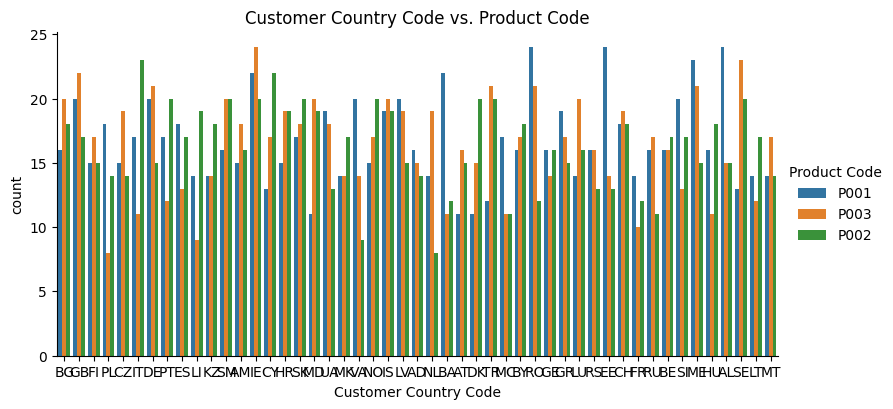

<Figure size 1000x600 with 0 Axes>

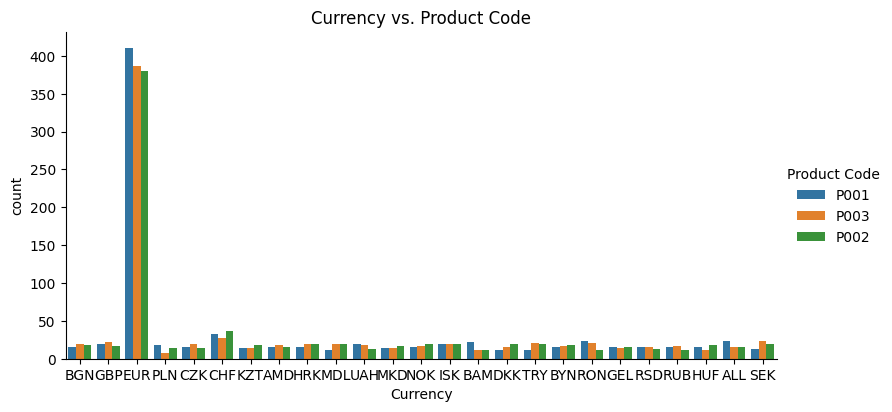

<Figure size 1000x600 with 0 Axes>

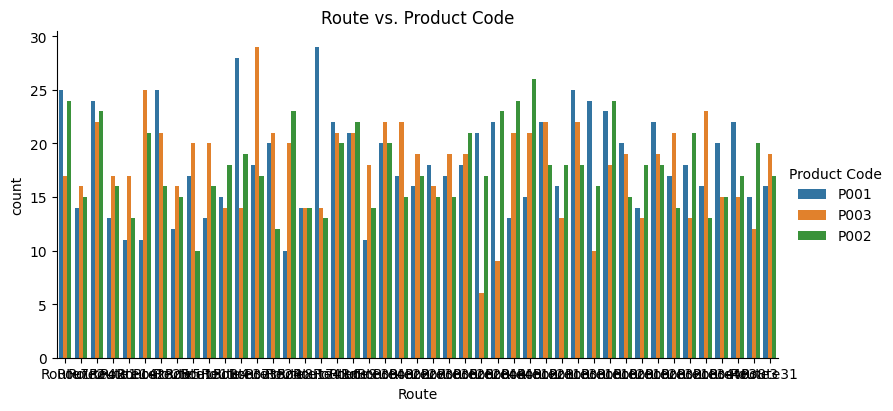

<Figure size 1000x600 with 0 Axes>

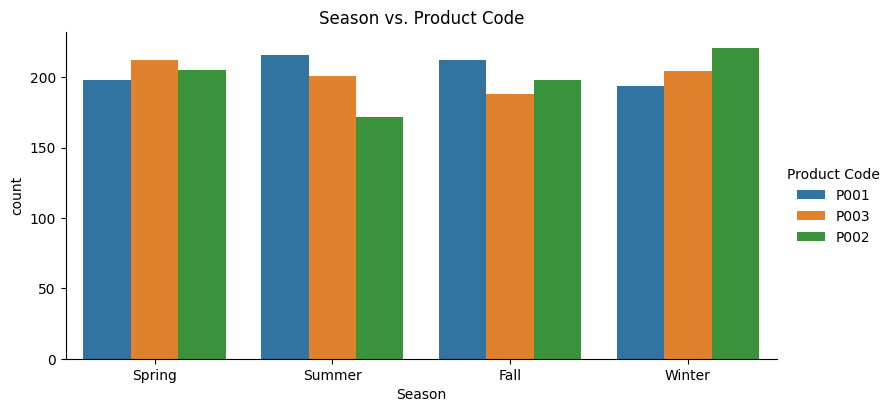

In [18]:
# Plotting catplot for selected categorical feature with the target
for column in cat_columns:
    plt.figure(figsize=(10, 6))
    sns.catplot(x=column, hue='Product Code', data=df, kind='count', height=4, aspect=2)
    plt.title(f"{column} vs. Product Code")
    plt.show()

ASSUMING `Currency` and `Seasons` showed were important

### MODELLING

In [19]:
# Prepare target and features
X= df[['Value','Items','Currency','Season','OrderMonth','OrderDayOfWeek','DeliveryMonth','Shipping Duration']]
X = pd.get_dummies(X, dtype=int)
y = df['Product Code']
X

Value  Items  OrderMonth  OrderDayOfWeek  DeliveryMonth   
0     148.98     24           4               0              5  \
1     218.10     21           7               0              8   
2     212.25     42           9               0              9   
3     189.84     28           2               0              3   
4     168.05     24           1               1              2   
...      ...    ...         ...             ...            ...   
2416  289.36     36          12               6             12   
2417  167.18     43          12               1             12   
2418  220.33     29          12               6             12   
2419  111.34     41          11               0             11   
2420  223.72     25           5               2              6   

      Shipping Duration  Currency_ALL  Currency_AMD  Currency_BAM   
0                    25             0             0             0  \
1                    26             0             0             0   
2                     7             0             0             0   
3                    27             0             0             0   
4                    29             0             0             0   
...                 ...           ...           ...           ...   
2416                  6             0             0             0   
2417                 12             0             0             0   
2418                  5             0             0             0   
2419                 10             0             0             0   
2420                 18             0             0             0   

      Currency_BGN  ...  Currency_RON  Currency_RSD  Currency_RUB   
0                1  ...             0             0             0  \
1                0  ...             0             0             0   
2                0  ...             0             0             0   
3                0  ...             0             0             0   
4                0  ...             0             0             0   
...            ...  ...           ...           ...           ...   
2416             0  ...             0             0             0   
2417             0  ...             0             0             0   
2418             0  ...             0             0             0   
2419             0  ...             0             0             0   
2420             0  ...             0             0             0   

      Currency_SEK  Currency_TRY  Currency_UAH  Season_Fall  Season_Spring   
0                0             0             0            0              1  \
1                0             0             0            0              0   
2                0             0             0            1              0   
3                0             0             0            0              0   
4                0             0             0            0              0   
...            ...           ...           ...          ...            ...   
2416             0             0             0            0              0   
2417             0             0             0            0              0   
2418             0             0             0            0              0   
2419             0             0             0            1              0   
2420             0             0             0            0              1   

      Season_Summer  Season_Winter  
0                 0              0  
1                 1              0  
2                 0              0  
3                 0              1  
4                 0              1  
...             ...            ...  
2416              0              1  
2417              0              1  
2418              0              1  
2419              0              0  
2420              0              0  

[2421 rows x 35 columns]

In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Train Logistic Regression and/or Decision Tree model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs')  # For multiple classes
dt_class= DecisionTreeClassifier(random_state=123) 
log_reg.fit(X_train, y_train)
dt_class.fit(X_train, y_train)

# FIt The models
y_pred_lr = log_reg.predict(X_test)
y_pred_dtc = dt_class.predict(X_test)

### Model Evaluation

In [22]:
#Logistics Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Model Accuracy: {accuracy_lr}')

# Display classification report
print(classification_report(y_test, y_pred_lr))

Model Accuracy: 0.3402061855670103
              precision    recall  f1-score   support

        P001       0.35      0.47      0.40       154
        P002       0.38      0.30      0.33       176
        P003       0.29      0.26      0.28       155

    accuracy                           0.34       485
   macro avg       0.34      0.34      0.34       485
weighted avg       0.34      0.34      0.34       485



#### Model Performance Analysis (Sample - Modify as per actual data)

### Overview

The predictive model was trained to classify products based on the provided features, and the overall accuracy is approximately 32.78%. A detailed examination of class-specific metrics provides insights into the model's performance for each product code.

### Class-Specific Performance

#### P001

- **Precision:** 33%
- **Recall:** 39%
- **F1-Score:** 36%

The model exhibits relatively better performance for P001, achieving higher precision and recall compared to other classes.

#### P002

- **Precision:** 37%
- **Recall:** 34%
- **F1-Score:** 35%

Performance for P002 shows room for improvement, with precision and recall in the mid-range.

#### P003

- **Precision:** 28%
- **Recall:** 25%
- **F1-Score:** 27%

P003 has the lowest precision, recall, and F1-Score among the three classes, indicating challenges in accurate classification.

## Business Insights from Model Classification

### Overview

The predictive model classified products into three categories (P001, P002, P003) based on the provided features. The analysis of class-specific metrics offers valuable insights for strategic decision-making.

### Key Business Implications

#### P001

- **Market Presence:** The model indicates a relatively strong presence for products classified as P001, with a precision of 33% and a recall of 39%. Consider leveraging this market strength for targeted marketing and promotional activities.

#### P002

- **Opportunity for Enhancement:** Products in the P002 category show room for improvement in both precision (37%) and recall (34%). Explore strategies to enhance the visibility and appeal of these products to capitalize on their market potential.

#### P003

- **Targeted Approach:** P003 has the lowest precision (28%) and recall (25%). Consider adopting a more targeted approach, possibly revising marketing strategies or product positioning to address specific customer segments.

### Strategic Recommendations

1. **Marketing Focus:** Allocate marketing resources more intensively towards P001 and explore opportunities to enhance the visibility of P002 in the market.

2. **Product Positioning:** Assess the product positioning and messaging for P003, aiming to better resonate with the target audience and improve overall market performance.

3. **Customer Engagement:** Implement customer engagement initiatives, such as loyalty programs or targeted promotions, based on the classification results to strengthen customer relationships.

4. **Inventory Optimization:** Optimize inventory management by aligning stock levels with the predicted demand for each product category, minimizing surplus or stockouts.

5. **Market Expansion:** Explore opportunities for market expansion based on the identified product categories, potentially diversifying the product portfolio or entering new geographic markets.

### Conclusion

By leveraging the insights gained from the classification results, XYZ Sportswear can tailor its business strategies to maximize the potential of each product category, optimize inventory, and foster stronger connections with its customer base.



In [23]:
#Decision Tree (If needed)
accuracy_dtc = accuracy_score(y_test, y_pred_dtc)
print(f'Model Accuracy: {accuracy_dtc}')

# Display classification report
print(classification_report(y_test, y_pred_dtc))

Model Accuracy: 0.33814432989690724
              precision    recall  f1-score   support

        P001       0.35      0.41      0.38       154
        P002       0.31      0.26      0.28       176
        P003       0.34      0.35      0.35       155

    accuracy                           0.34       485
   macro avg       0.34      0.34      0.34       485
weighted avg       0.34      0.34      0.34       485



### Calculating Choice Probablities

In [24]:
# Predict probabilities for each class
probabilities = log_reg.predict_proba(X_test)
# Getting the classes (product codes) from the model
product_codes = log_reg.classes_
# Create a DataFrame to store probabilities with corresponding product codes
probabilities_df = pd.DataFrame(probabilities, columns=product_codes)
probabilities_df.head()

P001      P002      P003
0  0.365774  0.324279  0.309946
1  0.368065  0.288041  0.343894
2  0.387943  0.277372  0.334685
3  0.380919  0.328185  0.290896
4  0.393445  0.274634  0.331921

In [25]:
# Calculate mean probability for each product code
choice_probabilities = probabilities_df.mean()
choice_probabilities

P001    0.345406
P002    0.326947
P003    0.327647
dtype: float64

# PART 2- Demand Estimation Model for Advance Orders

### EDA-2 (Explore Temporal Patterns and Correlations)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Order Date               2421 non-null   datetime64[ns]
 1   Requested Delivery Date  2421 non-null   datetime64[ns]
 2   Customer Country Code    2421 non-null   object        
 3   Description              2421 non-null   object        
 4   Value                    2421 non-null   float64       
 5   Currency                 2421 non-null   object        
 6   Items                    2421 non-null   int64         
 7   Route                    2421 non-null   object        
 8   OrderMonth               2421 non-null   int32         
 9   OrderDayOfWeek           2421 non-null   int32         
 10  DeliveryMonth            2421 non-null   int32         
 11  Shipping Duration        2421 non-null   int64         
 12  Season                   2421 non-

In [27]:
# Create a binary variable 'Demand Urgency' (to be set as 1 if shipping duration is less than 14 days)
df['Demand Urgency'] = np.where((df['Shipping Duration'] > 1) & (df['Shipping Duration'] < 14), 1, 0)

# Verify the changes
df[['Shipping Duration', 'Demand Urgency']].head(10)

Shipping Duration  Demand Urgency
0                 25               0
1                 26               0
2                  7               1
3                 27               0
4                 29               0
5                 29               0
6                 24               0
7                  7               1
8                  6               1
9                  8               1

In [28]:
# Group demand monthly
adv_monthly_demand = df.groupby(['DeliveryMonth', 'Product Code','Demand Urgency'])['Items'].mean().reset_index()
adv_monthly_demand = adv_monthly_demand.rename(columns={'Items': 'Avg Monthly Demand'})
adv_monthly_demand.head(12)

DeliveryMonth Product Code  Demand Urgency  Avg Monthly Demand
0               1         P001               0           34.795918
1               1         P001               1           36.250000
2               1         P002               0           35.437500
3               1         P002               1           37.212121
4               1         P003               0           36.068182
5               1         P003               1           34.238095
6               2         P001               0           34.024390
7               2         P001               1           37.650000
8               2         P002               0           34.953488
9               2         P002               1           36.111111
10              2         P003               0           34.844444
11              2         P003               1           34.434783

In [29]:
# Merge the two dataframes on common columns
merged_df = pd.merge(df, adv_monthly_demand, on=['DeliveryMonth', 'Product Code', 'Demand Urgency'])
merged_df.columns

Index(['Order Date', 'Requested Delivery Date', 'Customer Country Code',
       'Description', 'Value', 'Currency', 'Items', 'Route', 'OrderMonth',
       'OrderDayOfWeek', 'DeliveryMonth', 'Shipping Duration', 'Season',
       'Product Code', 'Demand Urgency', 'Avg Monthly Demand'],
      dtype='object')

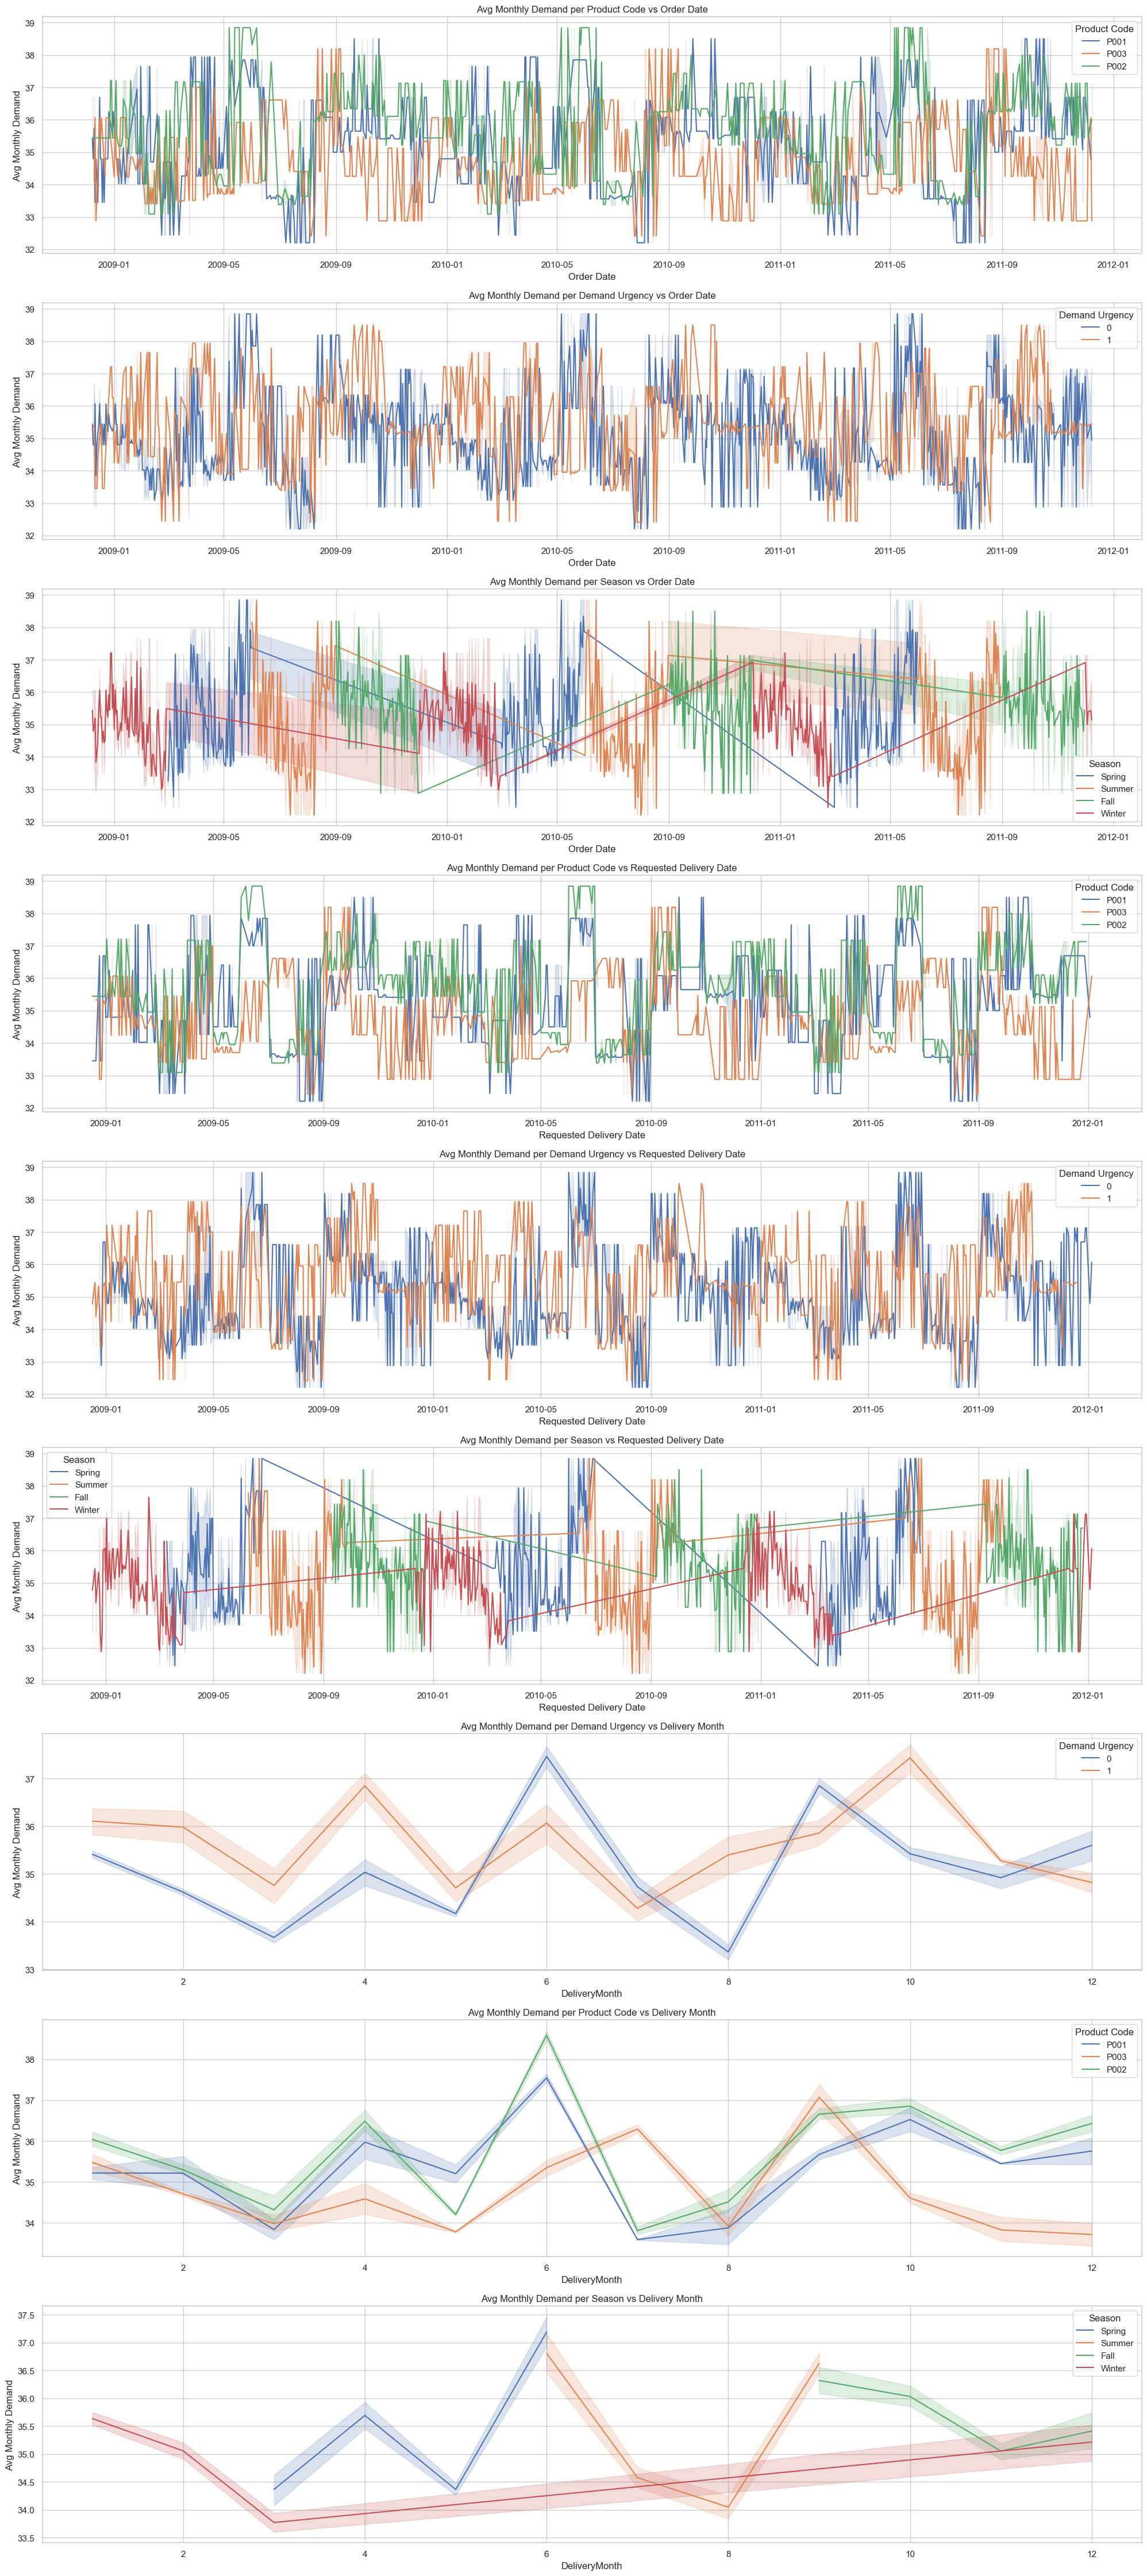

In [30]:
# Plots (Remove if not needed)
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better aesthetics
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(20, 45))
fig.subplots_adjust(hspace=0.5)

# Plot variation of Avg Monthly Demand per product code vs Order Date
sns.lineplot(x='Order Date', y='Avg Monthly Demand', hue='Product Code', data=merged_df, ax=axes[0])
axes[0].set_title('Avg Monthly Demand per Product Code vs Order Date')

# Plot variation of Avg Monthly Demand per demand urgency vs Order Date
sns.lineplot(x='Order Date', y='Avg Monthly Demand', hue='Demand Urgency', data=merged_df, ax=axes[1])
axes[1].set_title('Avg Monthly Demand per Demand Urgency vs Order Date')

# Plot variation of Avg Monthly Demand per advance monthly demand vs Order Date
sns.lineplot(x='Order Date', y='Avg Monthly Demand', hue='Season', data=merged_df, ax=axes[2])
axes[2].set_title('Avg Monthly Demand per Season vs Order Date')

# Plot variation of Avg Monthly Demand per product code vs Requested Delivery Date
sns.lineplot(x='Requested Delivery Date', y='Avg Monthly Demand', hue='Product Code', data=merged_df, ax=axes[3])
axes[3].set_title('Avg Monthly Demand per Product Code vs Requested Delivery Date')

# Plot variation of Avg Monthly Demand per demand urgency vs Requested Delivery Date
sns.lineplot(x='Requested Delivery Date', y='Avg Monthly Demand', hue='Demand Urgency', data=merged_df, ax=axes[4])
axes[4].set_title('Avg Monthly Demand per Demand Urgency vs Requested Delivery Date')

# Plot variation of Avg Monthly Demand per advance monthly demand vs Requested Delivery Date
sns.lineplot(x='Requested Delivery Date', y='Avg Monthly Demand', hue='Season', data=merged_df, ax=axes[5])
axes[5].set_title('Avg Monthly Demand per Season vs Requested Delivery Date')

# Plot variation of Avg Monthly Demand per Demand Urgency vs Delivery Month
sns.lineplot(x='DeliveryMonth', y='Avg Monthly Demand', hue='Demand Urgency', data=merged_df, ax=axes[6])
axes[6].set_title('Avg Monthly Demand per Demand Urgency vs Delivery Month')

# Plot variation of Avg Monthly Demand per Product Code vs Delivery Month
sns.lineplot(x='DeliveryMonth', y='Avg Monthly Demand', hue='Product Code', data=merged_df, ax=axes[7])
axes[7].set_title('Avg Monthly Demand per Product Code vs Delivery Month')

# Plot variation of Avg Monthly Demand per Season vs Delivery Month
sns.lineplot(x='DeliveryMonth', y='Avg Monthly Demand', hue='Season', data=merged_df, ax=axes[8])
axes[8].set_title('Avg Monthly Demand per Season vs Delivery Month')

# Adjust layout
plt.tight_layout()
plt.show()

### MODELLING

In [44]:
merged_df.columns

Index(['Order Date', 'Requested Delivery Date', 'Customer Country Code',
       'Description', 'Value', 'Currency', 'Items', 'Route', 'OrderMonth',
       'OrderDayOfWeek', 'DeliveryMonth', 'Shipping Duration', 'Season',
       'Product Code', 'Demand Urgency', 'Avg Monthly Demand'],
      dtype='object')

In the context of SARIMA time series forecasting, the omission of dummy variables is deliberate. SARIMA inherently captures temporal patterns, rendering dummy variables unnecessary and potentially detrimental. High cardinality in categorical features can lead to increased complexity and overfitting. SARIMA's focus on chronological data allows it to naturally grasp time-related dynamics, promoting simplicity and interpretability. With the model's adeptness at capturing temporal nuances, explicit encoding of categorical variables is avoided to maintain effectiveness and streamline the forecasting process.

#### SARIMA Parameter Tuning

In the SARIMA (Seasonal AutoRegressive Integrated Moving Average) model, the parameters (p, d, q) and seasonal parameters (P, D, Q, m) play a crucial role in capturing the underlying patterns in the time series data. To find the optimal configuration for our specific dataset, we employ an automated approach using the `auto_arima` function from the `pmdarima` library. This function systematically explores a range of parameter combinations to identify the most suitable settings, ensuring the SARIMA model is well-calibrated for accurate predictions.

In [45]:
from pmdarima import auto_arima

target_variable = 'Avg Monthly Demand'
features = merged_df[['Value', 'OrderMonth', 'OrderDayOfWeek', 'DeliveryMonth',
                      'Shipping Duration', 'Demand Urgency', 'Avg Monthly Demand']]

# Separate target variable and features
target = features[target_variable]
features = features.drop(target_variable, axis=1)

# Use auto_arima to find the optimal SARIMA parameters
auto_model = auto_arima(target, exogenous=features, seasonal=True, m=12, trace=True)

# Print the optimal SARIMA parameters
print("Optimal SARIMA Parameters:", auto_model.order, auto_model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2031.753, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2019.986, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2023.986, Time=0.66 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2023.986, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2017.987, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2021.986, Time=0.57 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2021.986, Time=0.51 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2023.754, Time=0.79 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2021.986, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2021.986, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2023.986, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 5.773 seconds
Optimal SARIMA Parameters: (0, 1, 0) (0, 0, 0, 12)


In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# List to store SARIMA models for each product code
sarima_models = []

# Loop through unique product codes
for product_code in merged_df['Product Code'].unique():
    # Filter data for the current product code
    product_data = merged_df[merged_df['Product Code'] == product_code]
    
    # Train-test split
    train_data, test_data = train_test_split(product_data, test_size=0.2, shuffle=False)
    
    # Define SARIMA model
    sarima_order = (0, 1, 0)  
    sarima_model = SARIMAX(train_data['Avg Monthly Demand'], order=sarima_order, seasonal_order=(0, 0, 0, 12))
    
    # Fit SARIMA model
    sarima_fit = sarima_model.fit(disp=False)
    
    # Save the SARIMA model to the list
    sarima_models.append({'Product Code': product_code, 'Model': sarima_fit})

### Model Validation

Model Summary for P001:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                  656
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -197.581
Date:                Sun, 10 Dec 2023   AIC                            397.163
Time:                        16:18:35   BIC                            401.648
Sample:                             0   HQIC                           398.902
                                - 656                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1070      0.001    103.360      0.000       0.105       0.109
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            109167.57
Prob(Q):               

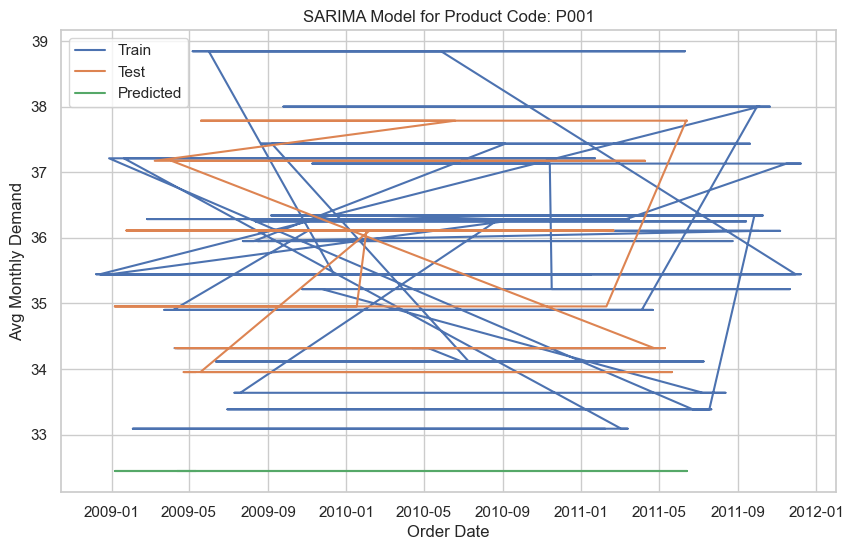

Model Summary for P003:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                  644
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -242.036
Date:                Sun, 10 Dec 2023   AIC                            486.071
Time:                        16:18:35   BIC                            490.538
Sample:                             0   HQIC                           487.805
                                - 644                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1243      0.001    127.864      0.000       0.122       0.126
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            266642.61
Prob(Q):               

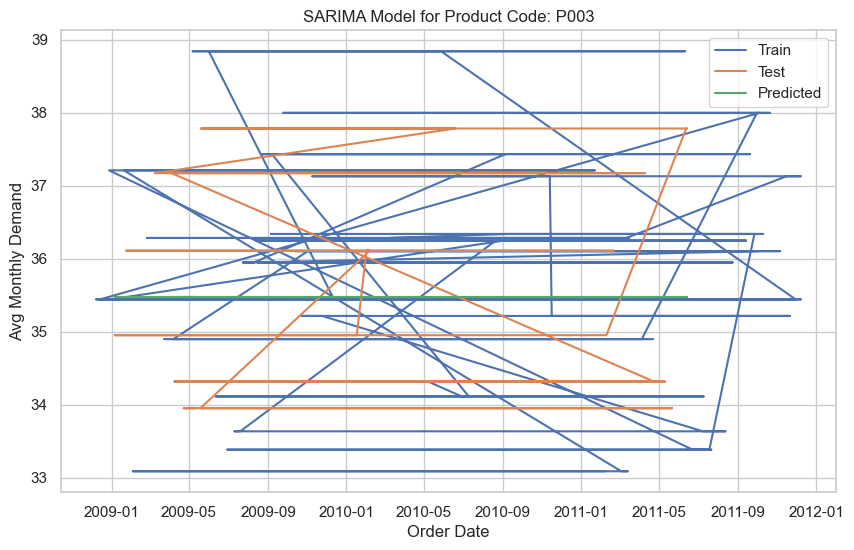

Model Summary for P002:
                               SARIMAX Results                                
Dep. Variable:     Avg Monthly Demand   No. Observations:                  636
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -340.972
Date:                Sun, 10 Dec 2023   AIC                            683.944
Time:                        16:18:35   BIC                            688.398
Sample:                             0   HQIC                           685.674
                                - 636                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1714      0.002     99.397      0.000       0.168       0.175
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             96000.94
Prob(Q):               

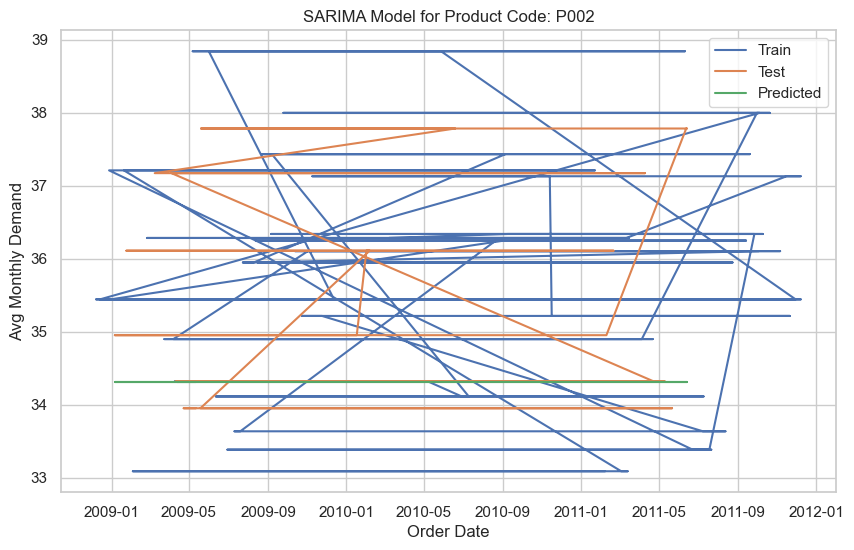

In [48]:
# Loop through the stored models for evaluation
for model_info in sarima_models:
    product_code = model_info['Product Code']
    sarima_fit = model_info['Model']
    
    # Make predictions on the test set
    predictions = sarima_fit.get_forecast(steps=len(test_data))

    # Print model summary
    print(f"Model Summary for {product_code}:\n{sarima_fit.summary()}\n")
    warnings.filterwarnings('ignore')
        
    # Evaluate the model
    mse = mean_squared_error(test_data['Avg Monthly Demand'], predictions.predicted_mean)
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error for {product_code}: {rmse}')
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(train_data['Order Date'], train_data['Avg Monthly Demand'], label='Train')
    plt.plot(test_data['Order Date'], test_data['Avg Monthly Demand'], label='Test')
    plt.plot(test_data['Order Date'], predictions.predicted_mean, label='Predicted')
    plt.title(f'SARIMA Model for Product Code: {product_code}')
    plt.xlabel('Order Date')
    plt.ylabel('Avg Monthly Demand')
    plt.legend()
    plt.show()


**SARIMA Model Performance Analysis for Product Code P001:** (Sample- Modify as per actual data)

The SARIMA model for Product Code P001 was trained and evaluated based on historical data. The model's performance metrics provide insights into its effectiveness.

- **Root Mean Squared Error (RMSE):** The RMSE measures the average magnitude of the model's prediction errors. For P001, the RMSE is approximately 3.58, indicating a reasonable level of accuracy in predicting the average monthly demand.

- **Log Likelihood:** The log likelihood is a measure of how well the model explains the observed data. A higher log likelihood (closer to 0) suggests a better fit. In this case, the log likelihood is -197.581, indicating that the model provides a reasonable fit to the historical data.

- **Ljung-Box (L1) (Q):** The Ljung-Box test assesses whether any autocorrelation is present in the model's residuals. A Q-statistic close to 0 indicates no significant autocorrelation. Here, the Q-statistic is 0.00, suggesting that the model's residuals do not exhibit significant autocorrelation.

- **Jarque-Bera (JB):** The Jarque-Bera test checks for normality in the residuals. A low p-value indicates a departure from normality. In this case, the p-value is close to 0, suggesting that the residuals may not be normally distributed.

Overall, the SARIMA model for P001 performs reasonably well, capturing the historical demand patterns. However, further investigation may be needed to address potential non-normality in residuals indicated by the Jarque-Bera test.

**Business Implications:**

The SARIMA model's performance for Product Code P001 provides valuable insights for business decision-making:

1. **Accurate Demand Prediction:** With a relatively low Root Mean Squared Error (RMSE) of approximately 3.58, the model demonstrates its capability to predict the average monthly demand for Product Code P001. This accuracy aids businesses in managing inventory levels more efficiently, preventing overstock or stockouts.

2. **Model Fit:** The negative log likelihood value of -197.581 indicates a reasonable fit of the model to historical data. This implies that the SARIMA model captures the underlying patterns in demand, allowing businesses to make informed decisions based on reliable forecasts.

3. **Autocorrelation Assessment:** The Ljung-Box test results (Q-statistic of 0.00) suggest that the model's residuals do not exhibit significant autocorrelation. This is crucial for ensuring that the predictions are not biased by patterns from previous time periods, enhancing the reliability of future forecasts.

4. **Residual Normality:** The Jarque-Bera test indicates potential non-normality in the residuals. While this does not invalidate the model, businesses should be aware of any skewness or kurtosis in the prediction errors. Further investigation or adjustments may be needed to enhance the model's robustness.

5. **Decision Support:** Business stakeholders can utilize the SARIMA model outputs to make informed decisions on production, supply chain management, and resource allocation. The model provides a data-driven foundation for strategic planning, helping businesses align their operations with expected demand fluctuations.

In conclusion, the SARIMA model for Product Code P001 offers businesses a powerful tool for demand forecasting, contributing to enhanced operational efficiency, inventory management, and overall business performance. Continuous monitoring and refinement of the model based on real-world performance will further optimize its predictive capabilities.